<a href="https://colab.research.google.com/github/Jay-Damodaran/PersonalProjects/blob/main/Projects/titanicproblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score as acc
from sklearn.ensemble import RandomForestClassifier as RFC

# Loading Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving titanictest.csv to titanictest.csv
Saving titanictrain.csv to titanictrain.csv


In [ ]:
train = pd.read_csv('titanictrain.csv')
test = pd.read_csv('titanictest.csv')
train

In [28]:
# data from drive
train = pd.read_csv('/content/drive/MyDrive/Datasets/titanictrain.csv')
test = pd.read_csv('/content/drive/MyDrive/Datasets/titanictest.csv')
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Preliminary Visualization

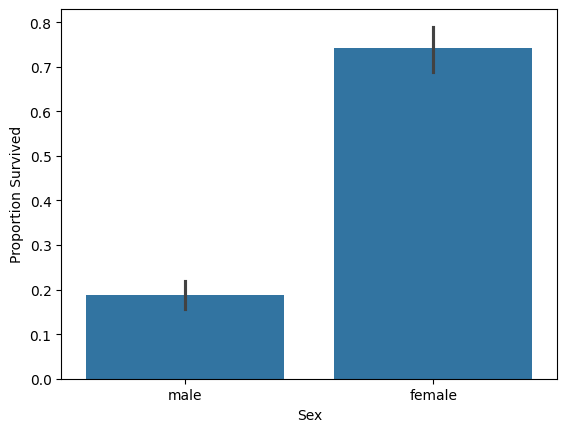

In [3]:
def categorical_plot(x_var, y_var):
    sns.barplot(train, x = x_var, y = y_var)
    plt.ylabel('Proportion Survived')

categorical_plot('Sex', 'Survived') # Sex is a really strong predictor of survival

# Preprocessing

In [4]:
# reusing cleaning and imputing functions creating during house price regression problem
# see that notebook for more detailed comments on these functions
def clean(dataframe):
    null_dataframe = pd.isnull(dataframe)
    Nan_dataframe = pd.DataFrame(columns = ['Name', 'Type', 'Nan count', 'Nan %'])
    for column in dataframe:
        if len(pd.unique(dataframe[column])) == 1:
            dataframe.drop(columns=column, inplace=True)
        elif all(cell == False for cell in null_dataframe[column]):
            if pd.api.types.is_numeric_dtype(dataframe[column]):
                Nan_dataframe.loc[len(Nan_dataframe.index)] = [column, 'Quantitative', 0, 0]
            else:
                Nan_dataframe.loc[len(Nan_dataframe.index)] = [column, 'Categorical', 0, 0]
        else:
            Nan_count = 0
            total_count = len(dataframe[column])
            for cell in null_dataframe[column]:
                if cell:
                    Nan_count += 1
            var_type = ''
            if pd.api.types.is_numeric_dtype(dataframe[column]):
                var_type = "Quantitative"
            else:
                var_type = "Categorical"
            Nan_dataframe.loc[len(Nan_dataframe.index)] = [column, var_type, Nan_count, Nan_count / total_count * 100]
            dataframe = impute_Nan(dataframe, Nan_dataframe, column)
    return dataframe, Nan_dataframe


def impute_Nan(dataframe, Nan_df, Var_name): # Nan_df must include a variable type column(quantitative or categorical) and name
    null_df = pd.isnull(dataframe)
    new_Nan_df = Nan_df.set_index("Name", drop = False)
    row = new_Nan_df.loc[Var_name]
    if row['Type'].lower() == 'quantitative':
        dataframe[Var_name].fillna(dataframe[Var_name].median(), inplace = True)
    else:
        nul_sum = null_df[Var_name].sum()
        nul_rows = set()
        if nul_sum > 20:
            dataframe[Var_name].fillna('None', inplace = True)
        else:
            for i, val in enumerate(null_df[Var_name]):
                if val:
                    nul_rows.add(i)
            dataframe.drop(index = nul_rows, inplace = True)
            dataframe.reset_index(drop = True, inplace = True)
            null_df.drop(index = nul_rows, inplace = True)
            null_df.reset_index(drop = True, inplace = True)
    return dataframe

clean_train, df2 = clean(train)
clean_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,None,S
885,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
886,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,None,S
887,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
Id = clean_train['PassengerId']
Survival = clean_train['Survived']
Name = clean_train['Name']
clean_train.drop(columns = ['PassengerId', 'Survived', 'Name'], inplace = True)
clean_train

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,None,S
...,...,...,...,...,...,...,...,...,...
884,2,male,27.0,0,0,211536,13.0000,None,S
885,1,female,19.0,0,0,112053,30.0000,B42,S
886,3,female,28.0,1,2,W./C. 6607,23.4500,None,S
887,1,male,26.0,0,0,111369,30.0000,C148,C


# Ordinal Encoding

In [6]:
# Reusing ordinal encoding function from house price regression notebook
def catvar_encode(dataframe):
  for column in dataframe:
    if dataframe[column].dtype == 'O':
      encode_dictionary = {'None': 0}
      digit = 1
      for i, cell in enumerate(dataframe[column]):
        if cell in encode_dictionary:
          dataframe.loc[i, column] = encode_dictionary[cell]
        else:
          dataframe.loc[i, column] = digit
          encode_dictionary[cell] = digit
          digit += 1
  return dataframe
encoded_train = catvar_encode(clean_train)
encoded_train

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,1,22.0,1,0,1,7.2500,0,1
1,1,2,38.0,1,0,2,71.2833,1,2
2,3,2,26.0,0,0,3,7.9250,0,1
3,1,2,35.0,1,0,4,53.1000,2,1
4,3,1,35.0,0,0,5,8.0500,0,1
...,...,...,...,...,...,...,...,...,...
884,2,1,27.0,0,0,677,13.0000,0,1
885,1,2,19.0,0,0,678,30.0000,145,1
886,3,2,28.0,1,2,614,23.4500,0,1
887,1,1,26.0,0,0,679,30.0000,146,2


In [7]:
summary_df = pd.DataFrame(columns = ['Name', 'n', 'mean', 'standard dev', 'min', 'Q1', 'median', 'Q3', 'max'])
for column in train:
    if pd.api.types.is_numeric_dtype(train[column]):
        n = len(train[column])
        mu = train[column].mean()
        sigma = train[column].std()
        med = train[column].median()
        q1= train[column].quantile(0.25)
        q3 = train[column].quantile(0.75)
        minimum = train[column].min()
        maximum = train[column].max()
        summary_df.loc[len(summary_df.index)] = [column, n, mu, sigma, minimum, q1, med, q3, maximum]
summary_df

,Name,n,mean,standard dev,min,Q1,median,Q3,max
0,Pclass,889,2.311586,0.834700,1.00,2.0000,3.0000,3.0,3.0000
1,Age,889,29.315152,12.984932,0.42,22.0000,28.0000,35.0,80.0000
2,SibSp,889,0.524184,1.103705,0.00,0.0000,0.0000,1.0,8.0000
3,Parch,889,0.382452,0.806761,0.00,0.0000,0.0000,0.0,6.0000
4,Fare,889,32.096681,49.697504,0.00,7.8958,14.4542,31.0,512.3292


# Normalization and splits

In [8]:
# dividing dataframe into df with quantitative and df with categorical variables
new_df2 = df2.set_index('Name')
quan_df = pd.DataFrame()
cat_df = pd.DataFrame()
for col in encoded_train:
  if new_df2.loc[col, 'Type'].lower() == 'quantitative':
    quan_df[col] = encoded_train[col]
  else:
    cat_df[col] = encoded_train[col]

# removing less important features to determine how it affects accuracy
cat_df.drop(columns = ['Embarked', 'Cabin'], inplace = True)
quan_df.drop(columns = ['Pclass', 'SibSp', 'Parch'], inplace = True)
quan_df

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500
...,...,...
884,27.0,13.0000
885,19.0,30.0000
886,28.0,23.4500
887,26.0,30.0000


In [11]:
# normalizing quantitative variables and recombining dfs
sclr = RobustScaler()
scaled_quan = sclr.fit_transform(quan_df)
scaled_quan = pd.DataFrame(scaled_quan)
final_train = pd.concat([scaled_quan, cat_df], axis = 1)
final_train.columns = final_train.columns.astype(str)
final_train

,0,1,Sex,Ticket
0,-0.461538,-0.311813,1,1
1,0.769231,2.459687,2,2
2,-0.153846,-0.282598,2,3
3,0.538462,1.672674,2,4
4,0.538462,-0.277188,1,5
...,...,...,...,...
884,-0.076923,-0.062941,1,677
885,-0.692308,0.672856,2,678
886,0.000000,0.389358,2,614
887,-0.153846,0.672856,1,679


# Training and Evaluating Random Forest Classifier

0.9977502812148481


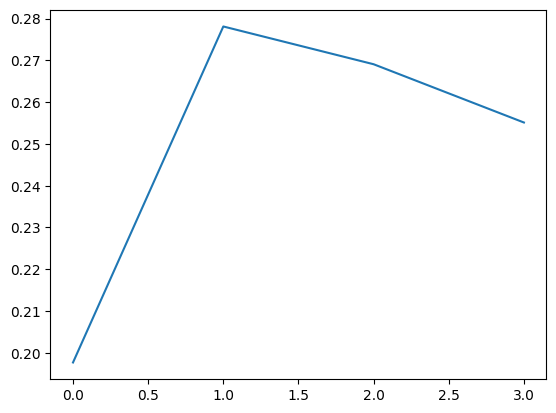

In [14]:
model = RFC()
model.fit(final_train, Survival)
prediction = model.predict(final_train)
accuracy = acc(Survival, prediction)
print(accuracy)
w = model.feature_importances_
plt.plot(w);

# Prediction on Test Data

In [29]:
Id = test['PassengerId']
Name = test['Name']
test.drop(columns = ['PassengerId', 'Name'], inplace = True)

In [23]:
# only difference is this cell has modified version of impute_nan function that can't drop rows
# since a prediction must be given for every element of the test sample
def clean(dataframe):
    null_dataframe = pd.isnull(dataframe)
    Nan_dataframe = pd.DataFrame(columns = ['Name', 'Type', 'Nan count', 'Nan %'])
    for column in dataframe:
        if len(pd.unique(dataframe[column])) == 1:
            dataframe.drop(columns=column, inplace=True)
        elif all(cell == False for cell in null_dataframe[column]):
            if pd.api.types.is_numeric_dtype(dataframe[column]):
                Nan_dataframe.loc[len(Nan_dataframe.index)] = [column, 'Quantitative', 0, 0]
            else:
                Nan_dataframe.loc[len(Nan_dataframe.index)] = [column, 'Categorical', 0, 0]
        else:
            Nan_count = 0
            total_count = len(dataframe[column])
            for cell in null_dataframe[column]:
                if cell:
                    Nan_count += 1
            var_type = ''
            if pd.api.types.is_numeric_dtype(dataframe[column]):
                var_type = "Quantitative"
            else:
                var_type = "Categorical"
            Nan_dataframe.loc[len(Nan_dataframe.index)] = [column, var_type, Nan_count, Nan_count / total_count * 100]
            dataframe = impute_Nan(dataframe, Nan_dataframe, column)
    return dataframe, Nan_dataframe

def impute_Nan(dataframe, Nan_df, Var_name): # Nan_df must include a variable type column(quantitative or categorical) and name
    null_df = pd.isnull(dataframe)
    new_Nan_df = Nan_df.set_index("Name", drop = False)
    row = new_Nan_df.loc[Var_name]
    if row['Type'].lower() == 'quantitative':
        dataframe[Var_name].fillna(dataframe[Var_name].median(), inplace = True)
    else:
        dataframe[Var_name].fillna('None', inplace = True)
    return dataframe

In [30]:
# imputing nans and encoding categorical variables
clean_test, test_nan_df = clean(test)
encoded_test = catvar_encode(clean_test)

In [ ]:
# splitting df into quantitative and categorical variable dfs
new_test_nan_df = test_nan_df.set_index('Name')
test_quan_df = pd.DataFrame()
test_cat_df = pd.DataFrame()
for col in encoded_test:
  if new_test_nan_df.loc[col, 'Type'].lower() == 'quantitative':
    test_quan_df[col] = encoded_test[col]
  else:
    test_cat_df[col] = encoded_test[col]

# must remove same features that model was trained without
test_cat_df.drop(columns = ['Embarked', 'Cabin'], inplace = True)
test_quan_df.drop(columns = ['Pclass', 'SibSp', 'Parch'], inplace = True)

In [37]:
# normalizing quantitative variables and recombining dfs
sclr = RobustScaler()
scaled_test_quan = sclr.fit_transform(test_quan_df)
scaled_test_quan = pd.DataFrame(scaled_test_quan)
final_test = pd.concat([scaled_test_quan, test_cat_df], axis = 1)
final_test.columns = final_test.columns.astype(str)
final_test

,0,1,Sex,Ticket
0,0.588235,-0.281005,1,1
1,1.568627,-0.316176,2,2
2,2.745098,-0.202184,1,3
3,0.000000,-0.245660,1,4
4,-0.392157,-0.091902,2,5
...,...,...,...,...
413,0.000000,-0.271640,1,359
414,0.941176,4.006002,2,360
415,0.901961,-0.305572,1,361
416,0.000000,-0.271640,1,362


In [38]:
test_predictions = model.predict(final_test)
test_predictions[:10] # predictions for first 10 entries. 1 means person was classified as a titanic survivor.

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0])

In [40]:
print(f'model estimates {sum(test_predictions) / len(test_predictions) * 100:.2f}% survived in testing set')

model estimates 34.45% survived in testing set
